In [1]:
%matplotlib notebook
import os
import csv
import tikzplotlib
import numpy as np
import pandas as pd
import kmapper as km
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from kmapper import jupyter
from itertools import cycle
from sklearn import metrics
from collections import OrderedDict
from sklearn.cluster import KMeans, AgglomerativeClustering, OPTICS
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

sns.set_style('whitegrid')

## Load extracted features

In [2]:
DATASET_NAME = "categorical_pathcontext"
os.makedirs(f"./results/tables/{DATASET_NAME}")
os.makedirs(f"./results/figures/{DATASET_NAME}")

In [3]:
# Load code vectors and labels
vectors = pd.read_csv(f'./data/{DATASET_NAME}/{DATASET_NAME}.test.c2v.vectors', sep=" ", header=None)
labels = pd.read_csv(f'./data/{DATASET_NAME}/{DATASET_NAME}.test.c2v', sep=" ").iloc[:, 0]

embedding_dim = vectors.values.shape[1]

# Merge vectors and labels
df = vectors.assign(method_name=labels)
df.dropna(inplace=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,375,376,377,378,379,380,381,382,383,method_name
0,-0.192808,0.128637,0.556854,-0.133035,-0.629438,0.251946,0.092517,-0.169161,0.463354,-0.805564,...,-0.524623,0.613447,0.023931,0.018524,0.011242,0.655006,-0.349756,0.366634,0.367900,forward
1,-0.295853,-0.326589,0.138830,-0.472909,-0.387840,0.102327,-0.331740,-0.037185,0.220041,-0.146624,...,-0.605164,0.394230,0.195770,-0.458297,0.426864,0.493846,-0.413191,0.563986,-0.372423,train
2,-0.357210,-0.095805,-0.035323,-0.300480,-0.605678,0.391631,-0.538174,0.034845,0.182166,-0.256405,...,-0.238271,0.394339,0.059702,0.118138,0.354062,0.618421,-0.506903,0.336578,-0.559207,train
3,-0.383817,0.184923,0.569010,-0.322974,-0.568950,0.377259,-0.015696,-0.303352,0.383378,-0.767766,...,-0.621367,0.661651,-0.089353,-0.280108,-0.020270,0.715288,-0.563392,0.551654,0.257718,forward
4,-0.514689,0.026242,0.022658,0.089862,-0.779376,0.451862,-0.143023,0.010953,0.095094,-0.715401,...,0.021206,0.686553,0.438103,0.750322,-0.078380,0.810036,-0.452736,0.142773,-0.529890,save


## Data preparation

In [4]:
classes = { 0: 'train', 1: 'save', 2: 'process', 3: 'forward', 4: 'predict' }

In [5]:
# Assign categories based on method name
df['category'] = df.method_name.map(lambda x: np.array([x.find(s) for s in classes.values()]).argmax())
df

,0,1,2,3,4,5,6,7,8,9,...,376,377,378,379,380,381,382,383,method_name,category
0,-0.192808,0.128637,0.556854,-0.133035,-0.629438,0.251946,0.092517,-0.169161,0.463354,-0.805564,...,0.613447,0.023931,0.018524,0.011242,0.655006,-0.349756,0.366634,0.367900,forward,3
1,-0.295853,-0.326589,0.138830,-0.472909,-0.387840,0.102327,-0.331740,-0.037185,0.220041,-0.146624,...,0.394230,0.195770,-0.458297,0.426864,0.493846,-0.413191,0.563986,-0.372423,train,0
2,-0.357210,-0.095805,-0.035323,-0.300480,-0.605678,0.391631,-0.538174,0.034845,0.182166,-0.256405,...,0.394339,0.059702,0.118138,0.354062,0.618421,-0.506903,0.336578,-0.559207,train,0
3,-0.383817,0.184923,0.569010,-0.322974,-0.568950,0.377259,-0.015696,-0.303352,0.383378,-0.767766,...,0.661651,-0.089353,-0.280108,-0.020270,0.715288,-0.563392,0.551654,0.257718,forward,3
4,-0.514689,0.026242,0.022658,0.089862,-0.779376,0.451862,-0.143023,0.010953,0.095094,-0.715401,...,0.686553,0.438103,0.750322,-0.078380,0.810036,-0.452736,0.142773,-0.529890,save,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2940,-0.457572,0.187244,-0.463191,0.380811,-0.777013,-0.524861,-0.763137,-0.729501,0.531019,-0.232472,...,0.706413,-0.740922,0.502451,-0.215505,0.539323,-0.450186,0.193539,0.293145,train,0
2941,-0.546144,-0.180330,0.145406,-0.448565,-0.564492,0.323737,-0.340131,-0.282830,-0.045824,0.093165,...,0.607432,-0.009347,-0.396269,0.271651,0.763809,-0.618999,0.614988,-0.330886,forward,3
2942,-0.152848,0.171134,0.382524,-0.164421,-0.374694,0.077277,0.042257,-0.285722,0.379152,-0.687957,...,0.529273,0.011690,-0.057474,-0.007948,0.428494,-0.322198,0.276340,0.419927,train,0
2943,-0.350018,-0.000424,0.013366,-0.275749,-0.463614,-0.123646,-0.259949,-0.294772,0.458887,-0.456008,...,0.412801,0.343691,-0.124513,0.246655,0.362216,-0.349900,0.321875,0.141200,train,0


In [6]:
df.groupby('category').size()

category
0    976
1    424
2    409
3    611
4    525
dtype: int64

In [7]:
train_df, test_df = train_test_split(df, test_size=0.2) 

In [8]:
train_features = train_df.iloc[:, 0:embedding_dim].values
test_features = test_df.iloc[:, 0:embedding_dim].values

In [9]:
train_features.shape, test_features.shape

((2356, 384), (589, 384))

## Train an Autoencoder to (optionally) reduce the dimensionality of the features

In [10]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
          layers.Flatten(),
          layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(embedding_dim, activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [11]:
## Train autoencoder

latent_dim = 10
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.fit(train_features, train_features,
                epochs=20,
                shuffle=True,
                validation_data=(test_features, test_features),
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3)])

Epoch 1/20
74/74 [==============================] - 1s 6ms/step - loss: 0.3306 - val_loss: 0.1241
Epoch 2/20
74/74 [==============================] - 0s 2ms/step - loss: 0.1157 - val_loss: 0.1156
Epoch 3/20
74/74 [==============================] - 0s 1ms/step - loss: 0.1091 - val_loss: 0.1113
Epoch 4/20
74/74 [==============================] - 0s 1ms/step - loss: 0.1067 - val_loss: 0.1084
Epoch 5/20
74/74 [==============================] - 0s 1ms/step - loss: 0.1043 - val_loss: 0.1047
Epoch 6/20
74/74 [==============================] - 0s 1ms/step - loss: 0.1003 - val_loss: 0.1033
Epoch 7/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0979 - val_loss: 0.1023
Epoch 8/20
74/74 [==============================] - 0s 2ms/step - loss: 0.1002 - val_loss: 0.1015
Epoch 9/20
74/74 [==============================] - 0s 1ms/step - loss: 0.0966 - val_loss: 0.1008
Epoch 10/20
74/74 [==============================] - 0s 1ms/step - loss: 0.0965 - val_loss: 0.1002
Epoch 11/20
74/74 [

## Choose a subset of samples
We'll only consider a subset of samples for visualization. This is done by taking an equal number of instances from each category.

In [12]:
df_subset = df.groupby('category').apply(lambda grp: grp.sample(n=100)).reset_index(level=[0, 1], drop=True)
df_subset.groupby('category').size()

category
0    100
1    100
2    100
3    100
4    100
dtype: int64

In [13]:
# Choose the "default" high dim features
dim = "high"
features = df_subset.iloc[:, 0:embedding_dim].values

# Map the features into a low dimensional space using the encoder
# dim = "low"
# features = autoencoder.encoder(df_subset.iloc[:, 0:embedding_dim].values).numpy()
features.shape

(500, 384)

### Declare methods for computing metrics and visualizing clusters

In [14]:
def calculate_metrics(estimator, dataframe, predicted_labels):
    features = dataframe.iloc[:, 0:embedding_dim].values
    results = {}
    results['estimator'] = estimator.__class__.__name__
    results['homogeneity_score'] = metrics.homogeneity_score(dataframe['category'], predicted_labels)
    results['completeness_score'] = metrics.completeness_score(dataframe['category'], predicted_labels)
    results['v_measure_score'] = metrics.v_measure_score(dataframe['category'], predicted_labels)
    results['adjusted_rand_score'] = metrics.adjusted_rand_score(dataframe['category'], predicted_labels)
    results['adjusted_mutual_info_score'] = metrics.adjusted_mutual_info_score(dataframe['category'], predicted_labels)
    results['average_jaccard_score'] = np.mean(metrics.jaccard_score(dataframe['category'], predicted_labels, average=None))
    results['silhouette_score'] = metrics.silhouette_score(features, predicted_labels, metric='sqeuclidean')
    return results

def plot_clusters(estimator, dataframe, labels, metrics):
    estimator_name = estimator.__class__.__name__
    
    k = len(np.unique(labels))
    # Print metrics
    print('Number of clusters: %d' % k)
    print("Homogeneity: %0.3f" % metrics['homogeneity_score'])
    print("Completeness: %0.3f" % metrics['completeness_score'])
    print("V-measure: %0.3f" % metrics['v_measure_score'])
    print("Adjusted Rand Index: %0.3f"
          % metrics['adjusted_rand_score'])
    print("Adjusted Mutual Information: %0.3f"
          % metrics['adjusted_mutual_info_score'])
    print("Mean Jaccard Coefficient: %s"
          % metrics['average_jaccard_score'])
    print("Silhouette Coefficient: %0.3f"
          % metrics['silhouette_score'])

    # Visualize clusters with tSNE
    fig = plt.figure(figsize=(14,6))
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_title(f'{estimator_name} Clusters (k={k})')
    colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    if estimator_name == 'OPTICS':
        ax1.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2], c='k', marker='+', alpha=0.1)
    for klass, color in zip(range(0, k), colors):
        Xk = tsne_result[labels == klass]
        ax1.scatter(Xk[:, 0], Xk[:, 1], Xk[:, 2], c=color, alpha=0.3, label=f'Cluster ID {klass}')

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title('Method names as labels')
    colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    for klass, color in zip(range(0, len(classes)), colors):
        Xk = tsne_result[dataframe['category'] == klass]
        ax2.scatter(Xk[:, 0], Xk[:, 1],  Xk[:, 2], c=color, alpha=0.3, label=classes[klass])
    ax2.legend()
    
    ax2.legend(title='Method name', bbox_to_anchor=(0.5, -0.2), loc='lower center', fancybox=True, ncol=klass+1)
    fig.tight_layout()
    plt.savefig(f"./results/figures/{DATASET_NAME}/code2vec_{dim}_dim_{DATASET_NAME}_{estimator.__class__.__name__}.svg")
    

def cv_silhouette_scorer(estimator, X):
    estimator.fit(X)
    if (estimator.__class__.__name__ == "OPTICS"):
        cluster_labels = estimator.labels_[estimator.ordering_]
    else:
        cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return metrics.silhouette_score(X, cluster_labels, metric='sqeuclidean')

In [15]:
# Use tSNE & clustering
tsne = TSNE(n_components=3, verbose=1, perplexity=30, n_iter=3000)
tsne_result = tsne.fit_transform(features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 1.357629
[t-SNE] KL divergence after 250 iterations with early exaggeration: 104.489098
[t-SNE] KL divergence after 3000 iterations: 1.050126


## Model fitting and hyperparameter search

In [16]:
estimators = OrderedDict()
estimator_metrics = OrderedDict()

### Centroid-based clustering using K-means

Best silhouette score 0.369 achieved with 2 clusters
Number of clusters: 2
Homogeneity: 0.002
Completeness: 0.004
V-measure: 0.003
Adjusted Rand Index: -0.001
Adjusted Mutual Information: -0.001
Mean Jaccard Coefficient: 0.06268315018315018
Silhouette Coefficient: 0.369


<IPython.core.display.Javascript object>


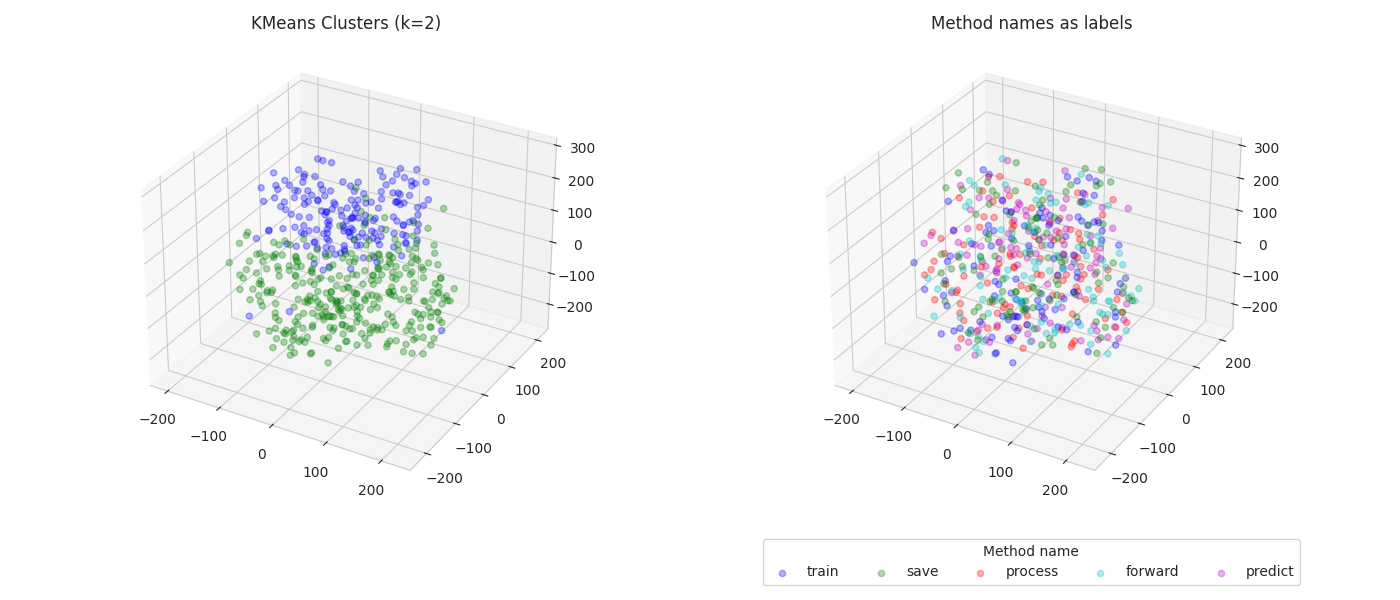

In [27]:
# Apply K-means
search_params = {'n_clusters': np.arange(2,11)}

cv = [(slice(None), slice(None))] # Disable cv, only want grid search
gs = GridSearchCV(estimator=KMeans(random_state=0), param_grid=search_params, 
                  scoring=cv_silhouette_scorer, cv=cv, n_jobs=-1)

res = gs.fit(X=features, y=None)

max_silhouette_score = np.max(res.cv_results_['mean_test_score'])
ind = np.argmax(res.cv_results_['mean_test_score'])
k = search_params['n_clusters'][ind]

print(f"Best silhouette score {max_silhouette_score:.3f} achieved with {k} clusters")
kmeans_estimator = KMeans(n_clusters=k, random_state=0)
kmeans_name = kmeans_estimator.__class__.__name__

kmeans = kmeans_estimator.fit(features)
kmeans_metrics = calculate_metrics(kmeans_estimator, df_subset, kmeans.labels_)
plot_clusters(kmeans, df_subset, kmeans.labels_, kmeans_metrics)

estimators[kmeans_name] = {'estimator': kmeans_estimator, 'score':  max_silhouette_score }
estimator_metrics[kmeans_name] = {'Estimator': kmeans_name, 'Adjusted Rand Index': kmeans_metrics['adjusted_rand_score'], 'Silhouette Score': kmeans_metrics['silhouette_score']}

### Density-Based Clustering using OPTICS

Best silhouette score 0.191 achieved with {'cluster_method': 'xi', 'metric': 'cosine', 'min_samples': 5, 'xi': 0.4}
Number of clusters: 10
Homogeneity: 0.216
Completeness: 0.380
V-measure: 0.276
Adjusted Rand Index: 0.036
Adjusted Mutual Information: 0.251
Mean Jaccard Coefficient: 0.03
Silhouette Coefficient: -0.366


<IPython.core.display.Javascript object>


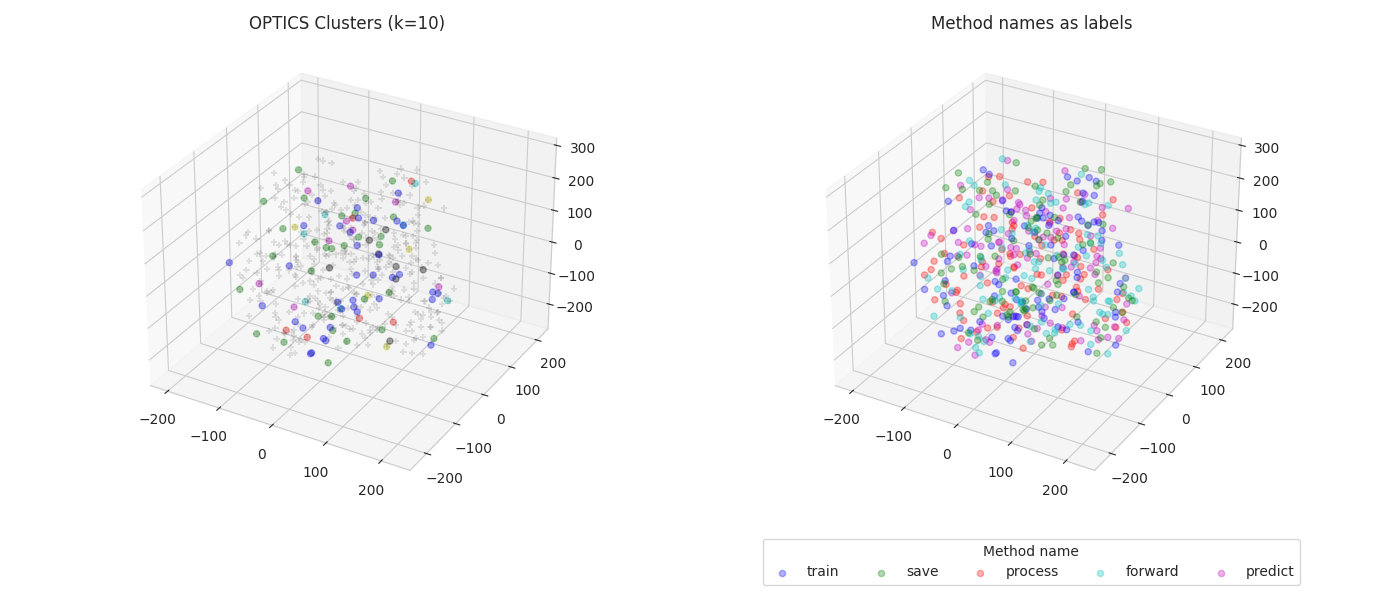

In [26]:
search_params = {'cluster_method': ['xi', 'dbscan'], 'xi': np.linspace(0,1,11), 'min_samples': [2,5,10,15,20,25,30], 'metric': ['minkowski', 'cosine', 'euclidean', 'sqeuclidean']}

cv = [(slice(None), slice(None))] # Disable cv, only want grid search
gs = GridSearchCV(estimator=OPTICS(cluster_method='xi'), param_grid=search_params, 
                  scoring=cv_silhouette_scorer, cv=cv, n_jobs=-1)

res = gs.fit(X=features, y=None)

# Get best configuration
max_silhouette_score = np.max(res.cv_results_['mean_test_score'])
ind = np.argmax(res.cv_results_['mean_test_score'])
best_params = res.cv_results_['params'][ind]
k = best_params['min_samples']
metric = best_params['metric']

# Visualize best clusters
print(f"Best silhouette score {max_silhouette_score:.3f} achieved with {res.cv_results_['params'][ind]}")
optics_estimator = OPTICS(cluster_method='xi', min_samples=k, metric=metric)
optics_name = optics_estimator.__class__.__name__

optics_clusters = optics_estimator.fit(features)
optics_metrics = calculate_metrics(optics_estimator, df_subset, optics_clusters.labels_[optics_clusters.ordering_])
plot_clusters(optics_clusters, df_subset, optics_clusters.labels_[optics_clusters.ordering_], optics_metrics)

estimators[optics_name] = {'estimator': optics_estimator, 'score':  max_silhouette_score }
estimator_metrics[optics_name] = {'Estimator': optics_name, 'Adjusted Rand Index': optics_metrics['adjusted_rand_score'], 'Silhouette Score': optics_metrics['silhouette_score']}

### Agglomerative Clustering (Hierarchical)

Best silhouette score 0.639 achieved with {'linkage': 'single', 'n_clusters': 2}
Number of clusters: 2
Homogeneity: 0.002
Completeness: 0.141
V-measure: 0.004
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.001
Mean Jaccard Coefficient: 0.03967935871743487
Silhouette Coefficient: 0.639


<IPython.core.display.Javascript object>


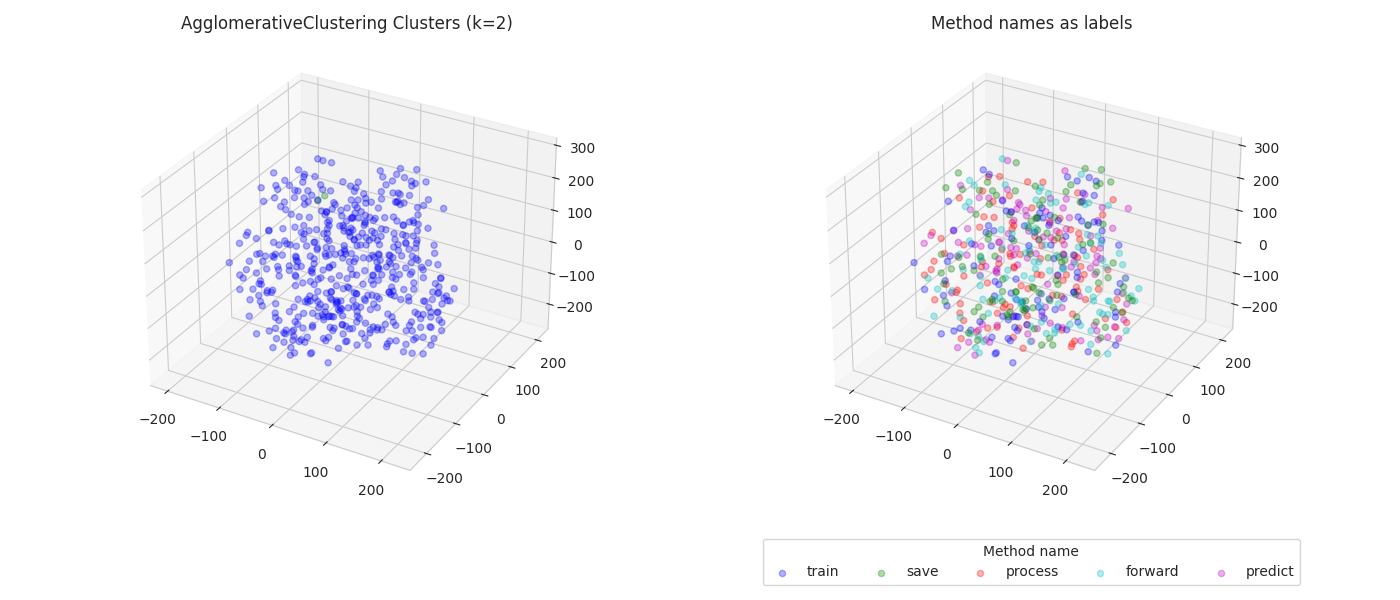

In [25]:
search_params = {'n_clusters': np.arange(2,11), 'linkage': ['ward', 'complete', 'average', 'single']}
# search_params = {'n_clusters': np.arange(2,11), 'linkage': ['complete', 'average', 'single'], 'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']}

cv = [(slice(None), slice(None))] # Disable cv, only want grid search
gs = GridSearchCV(estimator=AgglomerativeClustering(linkage='ward'), param_grid=search_params, 
                  scoring=cv_silhouette_scorer, cv=cv, n_jobs=-1)

res = gs.fit(X=features, y=None)

# Get best configuration
max_silhouette_score = np.max(res.cv_results_['mean_test_score'])
ind = np.argmax(res.cv_results_['mean_test_score'])
best_params = res.cv_results_['params'][ind]
k = best_params['n_clusters']
linkage = best_params['linkage']

# Visualize best clusters
print(f"Best silhouette score {max_silhouette_score:.3f} achieved with {res.cv_results_['params'][ind]}")
agglomerative_estimator = AgglomerativeClustering(n_clusters=k, linkage=linkage)
agglomerative_name = agglomerative_estimator.__class__.__name__

agglomerative_clusters = agglomerative_estimator.fit(features)
agglomerative_metrics = calculate_metrics(agglomerative_clusters, df_subset, agglomerative_clusters.labels_)
plot_clusters(agglomerative_clusters, df_subset, agglomerative_clusters.labels_, agglomerative_metrics)

estimators[agglomerative_name] = {'estimator': agglomerative_estimator, 'score':  max_silhouette_score}
estimator_metrics[agglomerative_name] = {'Estimator': agglomerative_name, 'Adjusted Rand Index': agglomerative_metrics['adjusted_rand_score'], 'Silhouette Score': agglomerative_metrics['silhouette_score']}

## Select best estimator

In [20]:
scores = [val['score'] for val in estimators.values()]
ind = np.argmax(scores)
best_estimator = list(estimators.values())[ind]['estimator']
print(f"Best cluster method: {best_estimator.__class__.__name__}\nParams:\n{best_estimator.__dict__}")

Best cluster method: AgglomerativeClustering
Params:
{'n_clusters': 2, 'distance_threshold': None, 'memory': None, 'connectivity': None, 'compute_full_tree': 'auto', 'linkage': 'single', 'affinity': 'euclidean', 'compute_distances': False, 'n_features_in_': 384, 'children_': array([[157, 165],
       [147, 341],
       [ 92, 136],
       [419, 388],
       [ 28, 286],
       [437, 243],
       [ 20, 392],
       [233,  57],
       [380, 503],
       [122,  87],
       [161, 217],
       [351, 418],
       [451, 263],
       [452, 354],
       [352, 365],
       [446, 338],
       [512, 301],
       [108, 504],
       [ 76, 347],
       [516, 402],
       [484,  98],
       [185,  77],
       [296, 256],
       [462, 427],
       [521, 500],
       [448, 508],
       [525, 127],
       [524, 519],
       [ 52,  27],
       [507, 142],
       [379, 383],
       [ 89, 527],
       [526, 486],
       [531,  14],
       [465, 498],
       [ 99, 357],
       [523, 511],
       [ 17, 434],
  

In [21]:
# Write configs of the best estimators from each category to file
with open(f"./results/code2vec_{dim}_dim_{DATASET_NAME}_estimators_config.txt", "w") as writer:
    for conf, score in [(val['estimator'].__dict__,val['score']) for val in estimators.values()]:
        writer.write(f"Estimator config:\n{conf}\nSilhouette Score: {score}\n\n")

In [22]:
# Write the chosen cluster metrics for the best models to table
latex_table = pd.DataFrame([d for d in estimator_metrics.values()], columns=['Estimator', 'Adjusted Rand Index', 'Silhouette Score']).to_latex(index=False, float_format="%.3f").replace('\\toprule', '\\hline').replace('\\midrule', '\\hline').replace('\\bottomrule','\\hline')
with open(f"./results/tables/{DATASET_NAME}/code2vec_{dim}_dim_{DATASET_NAME}_table.tex", "w") as writer:
    writer.write(latex_table)
    
# Write all cluster metrics to table
latex_table = pd.DataFrame([d for d in [kmeans_metrics, optics_metrics, agglomerative_metrics]]).to_latex(index=False, float_format="%.3f").replace('\\toprule', '\\hline').replace('\\midrule', '\\hline').replace('\\bottomrule','\\hline')
with open(f"./results/tables/{DATASET_NAME}/code2vec_{dim}_dim_{DATASET_NAME}_all_metrics_table.tex", "w") as writer:
    writer.write(latex_table)

## Visualize Clusters with Kepler Mapper

In [24]:
# Visualize with kepler map
mapper = km.KeplerMapper(verbose=1)

# Fit and transform data, use TSNE 
projected_data = mapper.fit_transform(features, projection=TSNE(n_components=2))

# Create the graph (we cluster on the projected data and suffer projection loss)
graph = mapper.map(
    projected_data,
    clusterer=best_estimator,
    cover=km.Cover(5, 0.3),
)

# Create the visualizations
print("Output graph examples to html")
mapper.visualize(
    graph,
    title=f"{DATASET_NAME} Mapper",
    path_html=f"./data/{DATASET_NAME}/{DATASET_NAME}_{dim}_dim_visualization.html",
    custom_tooltips=df_subset['category'].values
)

jupyter.display(path_html=f"./data/{DATASET_NAME}/{DATASET_NAME}_{dim}_dim_visualization.html")

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: TSNE()
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (500, 384)

..Projecting data using: 
	TSNE(verbose=1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 1.357629
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.906921
[t-SNE] KL divergence after 1000 iterations: 0.800258

..Scaling with: MinMaxScaler()

Mapping on data shaped (500, 2) using lens shaped (500, 2)

Creating 25 hypercubes.

Created 93 edges and 46 nodes in 0:00:00.010331.
Output graph examples to html
Wrote visualization to: ./data/categorical_pathcontext/categorical_pathcontext_high_dim_visualization.html


/home/marcus/.local/lib/python3.8/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
